# Xe-100 Serpent Results Analysis
This notebook performs analysis the reactor physics and 
performance of an MMR-like reactor
using different compositions of HALEU. The compositions are:
* Pure (U-235 and U-238 are the only uranium isotopes)
* EBR-II (HALEU produced from downblended EBR-II spent fuel)
* Y-12 (HALEU prodced from downblended HEU at Y-12)

The reactor physics/performance metrics considered include:
* k-eff
* neutron flux
* beta-eff
* temperature feedback coefficients. 

Each of these metrics are determined for the intial burnup step. The 
reactor is assumed to be in an isothermal state at 800K, except for the material 
temperatures varied to determine the temperature feedback coefficients. When 
calculating the temperature feedback coefficients, the fuel, coolant, moderator, 
and total fedback coefficients are calculated by varying the respective
material temperatures between 700 (A), 750 (B), 800 (C), 850 (D), and 900 (E) K.
The naming convention for the temeprature variations are fuel, coolant, moderator, 
such that ACC would mean that the fuel is at 700 K, the coolant is at 800 K, 
and the moderator is at 800 K. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import serpentTools
from serpentTools.settings import rc
import pandas as pd

In [49]:
def calculate_rho(k):
    '''
    Calculate the reactivity (rho) based on k
    
    Parameters:
    -----------
    k: int, float
        k-eff value 
    
    Returns:
    --------
    rho: float, int
       reactivity
    '''
    rho = (k-1)/k
    return rho

def calculate_feedback(rho, temps):
    '''
    Calcualtes feedback coefficient caused by changes in 
    material temepratures
    
    Parameters:
    -----------
    rho: array, list
        reactivity at each temperature
    temps: array, list
        material temperatures
    
    Returns:
    --------
    alpha_t: float
        reactivity feedback coefficient
    '''
    coeffs = np.polyfit(temps, rho, 1)
    return coeffs

def error_propagation(k_0, k_1, error_0, error_1, delta_T):
    '''
    Performs error propagation for the calculation 
    of the temperature feedback coefficients
    
    Parameters:
    -----------
    k_0: int, float
        k-eff at base temperature
    k_1: int, float
        k-eff at varied temperature
    error_0: int, float
        error for k_0 value
    error_1: int, float
        error for k_1
    delta_T: int, float
        change in temperature
    
    Returns
    -------
    prop_error: int, float
        propagated error
    '''
    prop_error = np.sqrt(
                         error_1**2*((1/delta_T)*(1/k_1**2))**2 +
                         error_0**2*(-(1/delta_T)*(1/k_0**2))**2
                        )
    return prop_error

In [3]:
out_files = {'results':{'pure':'pure_res.m'},
             'detectors':{'pure':'pure_det.m',
                          'ebr':{},
                          'y12':{}
            }}

## k-eff

In [4]:
# Setting up the k-eff dictionary for fuel composition analysis
k_eff = {'pure':{}, 'ebr2':{}, 'y12':{}}; k_eff_error = {'pure':{},'ebr2':{}, 'y12':{}}
for key in k_eff:
    k_eff[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
    k_eff_error[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}

In [14]:
for fuel in ['pure']:
    counter = 0
    for key in k_eff[fuel]:
        data = serpentTools.read(out_files['results'][fuel])
        k_eff[fuel][key] = data.resdata['absKeff'][counter][0]
        k_eff_error[fuel][key] = data.resdata['absKeff'][counter][1]
        counter +=1

SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/fail

IndexError: index 9 is out of bounds for axis 0 with size 9

## beta-eff

In [16]:
beta_eff = {'pure':0, 'ebr2':0, 'y12':0}; beta_eff_error = {'pure':0,'ebr2':0, 'y12':0}

In [17]:
for fuel in ['pure']:
    data = serpentTools.read(out_files['results'][fuel])
    universe = data.getUniv('0', timeDays = 0)
    beta_eff[fuel] = universe.gc['betaEff'][0]
    beta_eff_error[fuel] = universe.gcUnc['betaEff'][0]

SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [18]:
for fuel in beta_eff:
    print(f"beta_eff for {fuel.capitalize()} fuel: {beta_eff[fuel]} +/- {beta_eff_error[fuel]}")

beta_eff for Pure fuel: 0.0061459 +/- 0.00768
beta_eff for Ebr2 fuel: 0 +/- 0
beta_eff for Y12 fuel: 0 +/- 0


## Flux

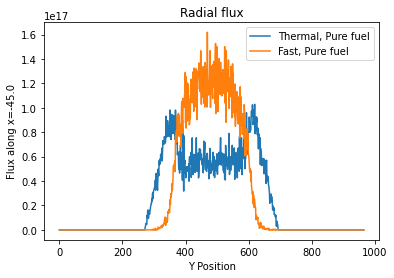

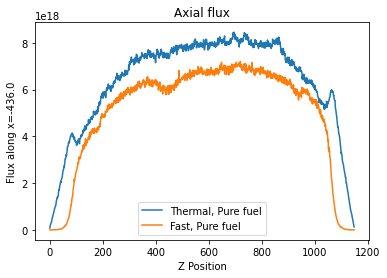

In [30]:
# Neutron flux for all base temperatures
for fuel in ['pure']:
        
        detectors = serpentTools.read(out_files['detectors'][fuel], 'det')
        radial = detectors.detectors['radial_flux']
        axial = detectors.detectors['axial_flux']
        
        plt.figure(counter)
        radial.plot(fixed={'energy':0, 'xmesh':438}, label=f'Thermal, {fuel.capitalize()} fuel')
        radial.plot(fixed={'energy':1, 'xmesh':438}, xlabel='Y Position',
                    ylabel = 'Flux along x={}'.format(radial.grids['X'][438,0]),
                    label=f'Fast, {fuel.capitalize()} fuel')
        plt.title(f"Radial flux")
        
        plt.figure(counter+1)
        axial.plot(fixed={'energy':0}, label=f'Thermal, {fuel.capitalize()} fuel')
        axial.plot(fixed={'energy':1}, label=f'Fast, {fuel.capitalize()} fuel', xlabel= 'Z Position',
                  ylabel = 'Flux along x={}'.format(axial.grids['Z'][139,0]))
        plt.title(f"Axial flux")

## Temperature feedback coefficients

In [53]:
rho = {'pure':{},'ebr':{}, 'y12':{}}
feedbacks = {'pure':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0},
             'ebr':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}, 
             'y12':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}}
for key in rho:
    rho[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
    rho_error[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
for fuel in ['pure']: 
    for key in rho[fuel]:
        rho[fuel][key] = calculate_rho(k_eff[fuel][key])

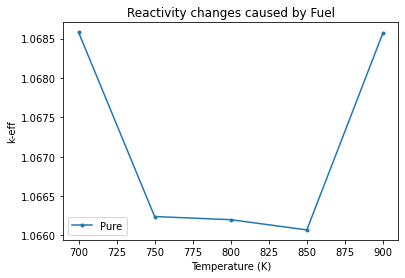

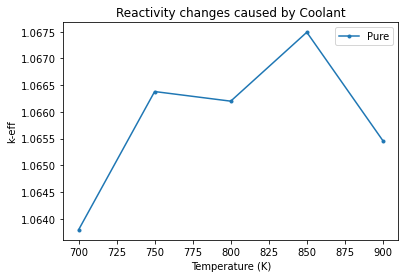

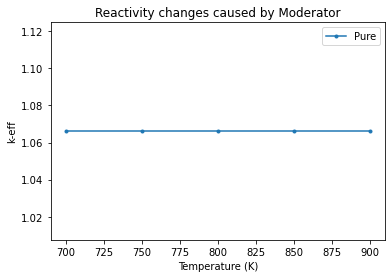

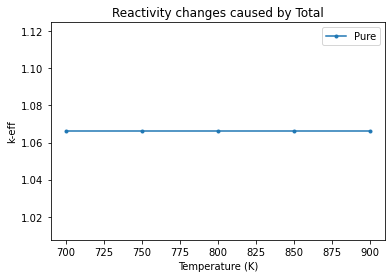

In [59]:
temps = [700, 750, 800, 850, 900]
for fuel in ['pure']:
    for m_index, material in enumerate(['fuel', 'coolant', 'moderator', 'total']):
        plt.figure(m_index)
        if material == 'fuel':
            data =[k_eff[fuel]['ACC'], k_eff[fuel]['BCC'], k_eff['pure']['CCC'], k_eff['pure']['DCC'], k_eff[fuel]['ECC']]
        if material == 'coolant':
            data =[k_eff[fuel]['CAC'], k_eff[fuel]['CBC'], k_eff['pure']['CCC'], k_eff['pure']['CDC'], k_eff[fuel]['CEC']]
        if material == 'moderator':
            data =[k_eff[fuel]['CCA'], k_eff[fuel]['CCB'], k_eff['pure']['CCC'], k_eff['pure']['CCD'], k_eff[fuel]['CCE']]
        if material == 'total':
            data =[k_eff[fuel]['AAA'], k_eff[fuel]['BBB'], k_eff['pure']['CCC'], k_eff['pure']['DDD'], k_eff[fuel]['EEE']]
        feedbacks[fuel][material], y_intercept = calculate_feedback(data, temps)
        
        plt.plot(temps, data, 
                 marker='.', label=f"{fuel.capitalize()}")
        plt.legend()
        plt.title(f"Reactivity changes caused by {material.capitalize()}")
        plt.xlabel('Temperature (K)')
        plt.ylabel('k-eff')

In [61]:
for fuel in ['pure']:
    for material in feedbacks[fuel]:
        print(fuel, material, feedbacks[fuel][material]*1e5)

pure fuel -0.03800000000007189
pure coolant 0.8899999999999338
pure moderator -2.1019592263693492e-13
pure total -2.1019592263693492e-13
